#Plant seedling recognition
Classification process will consist of next steps:

1. Get data — reading of images and labels
2. Cleaning data — removing of image background, input normalization and label preparatin
3. Model — creating training and validation sets, creating and fitting model
4. Evaluate model — evaluation of model, make prediction

## 1. Get data
Obtaining images and resizing to 70 x 70 px. We use a 70 x 70 px size for a quicker training of model. Also here we get image labels from folder name

In [ ]:
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

ScaleTo = 70 # px to scale
seed = 7

path = '/C:/Users/User/Downloads/skitbi cuet project file/cv project/Plant Seedling Classification Data/train/*/*.png'
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)


for img in files:
  print(str(j) + '/' + str(num), end='\r')
  trainImg.append(cv2.resize(cv2.imread(img),(ScaleTo,ScaleTo))) 
  trainLabel.append(img.split('/')[-2]) 
  j +=1

trainImg = np.asarray(trainImg) 
trainLabel = pd.DataFrame(trainLabel) 

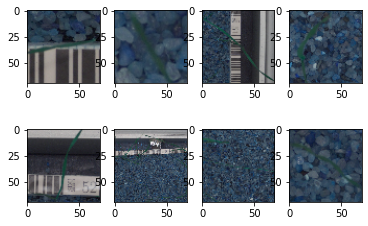

In [ ]:
# show some example images
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(trainImg[i])

As we can see, every photo of plant seedling has an background, so let's try to remove it. It'll help us to goal better model accuracy

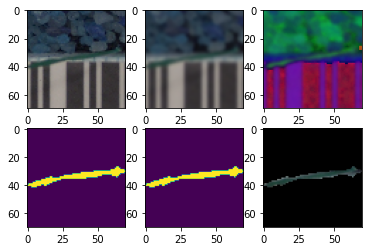

In [ ]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
  # Use gaussian blur
  blurImg = cv2.GaussianBlur(img, (5,5),0)

  # Convert to HSV image
  hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)

  # Create mask (parameters - green color range)
  lower_green = (25, 40, 50)
  upper_green = (75, 255, 255)
  mask = cv2.inRange(hsvImg, lower_green, upper_green)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)

  # Create bool mask
  bMask= mask >0

  # Apply the mask
  clear = np.zeros_like(img, np.uint8) 
  clear[bMask] = img[bMask] 
  clearTrainImg.append(clear) 

 
  if getEx:
    plt.subplot(2,3,1);plt.imshow(img) 
    plt.subplot(2,3,2);plt.imshow(blurImg) 
    plt.subplot(2,3,3);plt.imshow(hsvImg) 
    plt.subplot(2,3,4);plt.imshow(mask) 
    plt.subplot(2,3,5);plt.imshow(bMask) 
    plt.subplot(2,3,6);plt.imshow(clear) 
    getEx = False

clearTrainImg = np.asarray(clearTrainImg)

Good result! Let's look at other examples of masked images

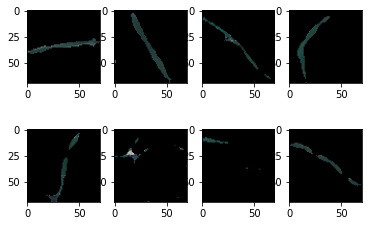

In [ ]:
# show sample results
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(clearTrainImg[i])

As we can see, we removed most of the background.

### 2.2. Normalize input

Now set the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]). CNN will be faster train if we use [0...1] input



In [ ]:
clearTrainImg = clearTrainImg /255

### 2.3. Categories labels

Now we encode image labels. Labels are 12 string names, so we could create classes array with this names, for example ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat' 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet'] and encode every label by position in this array. For example 'Charlock' -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

We need to encode all labels in this way.

Classes:['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes:12


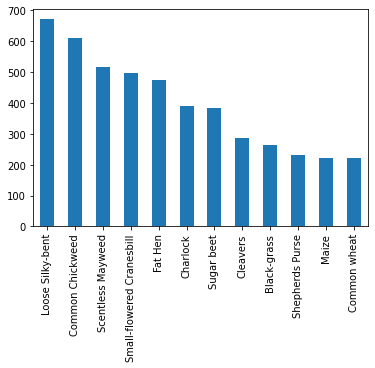

In [ ]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes:" + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes:" + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

As we can see, we have different counts of images of different species. So, data is unbalanced

### 3. Model
#### 3.1. Split dataset

Split data on training and validation set. 10% of data became the validation set

Our data is unbalanced, so for avoide inaccurate evaluation of model set stratify=clearTrainLabel

In [ ]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY, testY = train_test_split(clearTrainImg,clearTrainLabel,test_size=0.1,random_state=seed,stratify=clearTrainLabel)

#### 3.2. Data generator

To avoide overfitting we need to create image generator which will randomly rotate, zoom, shift and flip image during the fitting of the model.

* Set random rotation from 0 to 180 degrees
* Set random zoom at 0.1
* Set random shifting at 0.1
* Set horisontal and vertical flips

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=180, zoom_range = 0.1, width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,vertical_flip=True)
datagen.fit(trainX)

#### 3.3. Create model

For creation model i used Keras Sequential.

I created model with six convolutional layers and three fully-connected layers in the end. First two convolutional layers have 64 filters, next 128 filters and the last two layers have 256 filters. After each pair of convolution layers model have max pooling layer. Also, to reduce overfitting after each pair of convolution layers we use dropout layer (10% between convolutional layers and 50% between fully connect layers) and between each layer we use batch normalization layer.

In the end i used three fully-connected layers for classifing. In the last layer the neural net outputs destribution of probability for each of 12 classes.

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed) # Fix seed

model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(ScaleTo, ScaleTo, 3),activation="relu"))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))
model.summary()

# Compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       2

#### 3.4. Fit model

Here we'll train our model. Firstly, we set several callbacks. First callback reduce model learning rate. With high learning rate model quiker is the convergance, however with high learning rate the model could fall into a local minimum. So, we will decreace the learning rate at the process of fitting. We will reduce learning rate if the accuracy is not improved after for three epoch. Other two callbacks save best and last weights of model.


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc,',
patience=3,
verbose=1,
factor=0.4,
min_lr=0.00001)


filepath='/C:/Users/User/Downloads/skitbi cuet project file/cv project/Plant Seedling Classification Data/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode = 'max')
filepath = '/C:/Users/User/Downloads/skitbi cuet project file/cv project/Plant Seedling Classification Data/weights.last_auto4.hdf5'
checkpoint_all = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=False,mode='max')


callbacks_list = [checkpoint, learning_rate_reduction,checkpoint_all]

In [ ]:
ls

drive/  sample_data/


#### 4.1. Load model from file

Here we load the weights of best-fitting model from file (i used kaggle dataset with weights of model, which i trained earlier). Also i load from Data.npz training and validation data sets, on which model was fitting for evaluating of model accuracy.

In [ ]:
model.load_weights('drive/MyDrive/Colab Notebooks/weights.best_17-0.96.hdf5')

data = np.load('drive/MyDrive/Colab Notebooks/Data.npz')
d = dict(zip(('trainX','testX','trainY','testY'),(data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
trainY = d['trainY']
testY = d['testY']

print(model.evaluate(trainX,trainY)) 
print(model.evaluate(testX, testY)) 

134/134 [==============================] - 9s 11ms/step - loss: 0.0014 - accuracy: 0.9991
[0.0014229717198759317, 0.999532163143158]
15/15 [==============================] - 0s 19ms/step - loss: 0.2750 - accuracy: 0.9621
[0.27501168847084045, 0.9621052742004395]


#### 4.2. Confusion matrix

A good way to look at model errors.

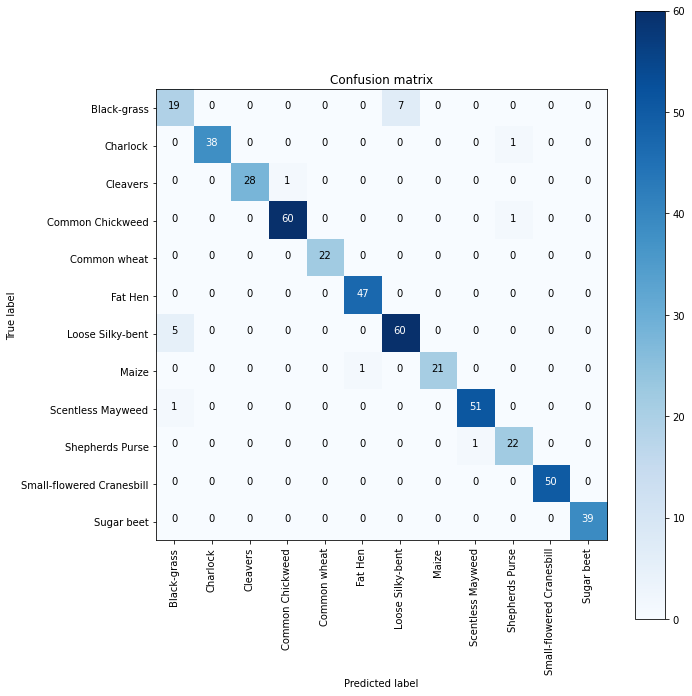

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 


confusionMTX = confusion_matrix(trueY, predYClasses) 


plot_confusion_matrix(confusionMTX, classes = le.classes_)

#### 4.3. Get results

And finnaly we get the result of prediction on test data.

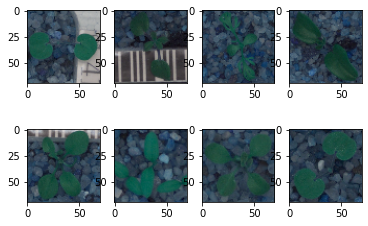

In [ ]:
path = '/C:/Users/User/Downloads/skitbi cuet project file/cv project/Plant Seedling Classification Data/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)


for img in files:
  print("Obtain images:"+ str(j) + '/' + str(num), end = '\r')
  testId.append(img.split('/')[-1]) # Images id's
  testImg.append(cv2.resize(cv2.imread(img),(ScaleTo,ScaleTo)))
  j +=1

testImg = np.asarray(testImg) 

for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(testImg[i])

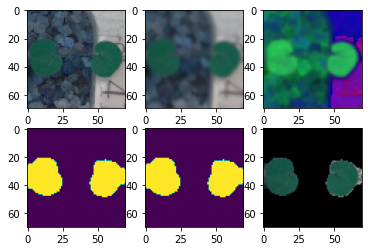

In [ ]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:

  blurImg = cv2.GaussianBlur(img,(5,5),0)

  hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)


  lower_green = (25,40,50)
  upper_green = (75,255,255)
  mask = cv2.inRange(hsvImg, lower_green, upper_green)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,kernel)


  bMask = mask > 0 


  clear = np.zeros_like(img,np.uint8)
  clear[bMask] = img[bMask] 
  clearTestImg.append(clear)

 
  if getEx:
    plt.subplot(2,3,1);plt.imshow(img) 
    plt.subplot(2,3,2);plt.imshow(blurImg) 
    plt.subplot(2,3,3);plt.imshow(hsvImg) 
    plt.subplot(2,3,4);plt.imshow(mask) 
    plt.subplot(2,3,5);plt.imshow(bMask) 
    plt.subplot(2,3,6);plt.imshow(clear) 
    getEx = False

clearTestImg = np.asarray(clearTestImg)

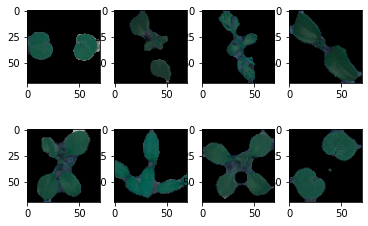

In [ ]:
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(clearTestImg[i])

In [ ]:
clearTestImg = clearTestImg / 255


In [ ]:
pred = model.predict(clearTestImg)


In [ ]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv('res.csv',index=False)

### SVM

In [ ]:
from keras.models import Model
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(trainX)
print(feat_train.shape)

feat_val = model_feat.predict(testX)
print(feat_val.shape)

feat_test = model_feat.predict(clearTestImg)
print(feat_test.shape)






(4275, 256)
(475, 256)
(794, 256)


In [ ]:
from sklearn import svm
clr = svm.SVC(kernel='rbf')
clr.fit(feat_train,np.argmax(trainY,axis=1))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:

clr.score(feat_train,np.argmax(trainY,axis=1))

0.9992982456140351

In [ ]:

clr.score(feat_val,np.argmax(testY,axis=1))

0.9621052631578947

In [ ]:
# Predict on [Test Festures]
Pred_labels = clr.predict(feat_test)